# Mel-Spectrogram

Quelques écoutes pour avoir une idée de la taille des spectrogrammes en E/S. Reconstruction audio par G&L

In [1]:
import numpy as np
from scipy.io import wavfile
import scipy
import pandas as pd
import librosa
import librosa.display
import time

import matplotlib.pyplot as plt
%matplotlib widget
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Audio

from synth import dexed

In [2]:
dexed_preset_db = dexed.PresetDatabase()
print("{} presets available".format(dexed_preset_db.get_nb_presets()))
chosen_algo = 5
preset_indexes = dexed_preset_db.get_preset_indexes_for_algorithm(chosen_algo)
print("{} presets using algorithm {}".format(len(preset_indexes), chosen_algo))

30762 presets available
3698 presets using algorithm 5


### Choix des paramètres du spectrogramme
* 22,050kHz par défaut dans librosa, d'autres ont choisi ça (on peut rester là-dessus...)
* Défault librosa
    * fft largeur 2048 (9,3ms) hopsize 512
* FlowSynth 2019
    * fft largeur 2048, hop 1024, 128 mel-bins de 30 à 11kHz
        * 128 mel-bins ça permet difficilement de reconstruire un son de DX7... (déjà sans AE)
    * log, normalized
    * corpus-wide zero-mean, unit-variance normalization on each spectrogram (based on the train dataset)
* Roche 2020
    * fft largeur 1024, hop 512, 513 lin freq bins de la STFT basique
    * log, energy-normalized, threshold -100dB
* Wavenet (modèle baseline avec spectrogramme) 2017
    * fft largeur 1024, fft hop 256
    * STFT linéaire ??? (à confirmer)
    * log magnitude du power spectrum
    * Constant-Q transform pour *l'affichage* des résultats
    * *Ou alors, encoder wavenet sur waveform directement*

### Utiliser un spectrogramme plutôt qu'un mel-spectrogramme ?
* $+$ représentation beaucoup plus fine du son, surtout pour un synthé comme le DX7
* $-$ pas d'échelle log pour les harmoniques, peut être un problème pour un CNN
* $+/-$ image à traiter est plus grande

In [3]:
t0 = time.time()
# Test pour voir si rendu temps-réel est viable. 5ms ouverture + 13ms pour 5s d'audio
for i in range(20):  # + rapide si petite boucle... (14ms total)
    dexed_renderer = dexed.Dexed()

    #idx = preset_indexes[1363]
    idx = 83
    preset = dexed_preset_db.get_preset_values(idx, plugin_format=True)
    dexed_renderer.assign_preset(preset)
    dexed_renderer.set_all_oscillators_on()
    dexed_renderer.set_default_general_filter_and_tune_params()
    dexed_renderer.prevent_SH_LFO()
    x_wav = dexed_renderer.render_note(60, 100)
print("Temps moyen pour ouvrir dexed (nouvelle classe) et générer l'audio = {:.1f}ms\n".format(1000.0*(time.time() - t0)/20.0))

Fs = dexed_renderer.Fs

print("Input audio")
Audio(x_wav, rate=Fs)

Temps moyen pour ouvrir dexed (nouvelle classe) et générer l'audio = 13.5ms

Input audio


In [4]:
# Default values for librosa melspectrogram
fft_width = 2048
print("fft_width : {:.1f}ms ({} linear freq bins per time step).".format(1000.0*fft_width/Fs, fft_width//2+1))
print("Freq resolution = {:.1f}Hz".format(Fs / fft_width))
fft_hop = 512
x_dB_min_th = -100.0  # Valeur min du log-spectre

# STFT array: last axis correspond to segment times
f_stft, t_stft, x_stft = scipy.signal.stft(x_wav, fs=Fs, nperseg=fft_width, noverlap=fft_width-fft_hop, padded=True)
print("spectrogram fft hop  : {:.1f}ms. {} time steps for {:.1f}s audio (padded)".format(1000.0*fft_hop/Fs, len(t_stft), x_wav.shape[0]/Fs))
print("STFT size : {}".format(x_stft.shape))
log_x_stft = np.maximum(20.0 * np.log10(np.abs(x_stft)), x_dB_min_th)

# Mel-spectrogram (and filter bank alone, for visualization)
n_mels = 256
f_mel_min = 30  # flow synth
f_mel_max = 11e3
melfb = librosa.filters.mel(Fs, fft_width, n_mels=n_mels, fmin=f_mel_min, fmax=f_mel_max)
mel_spectrogram = librosa.feature.melspectrogram(x_wav, sr=Fs, n_fft=fft_width, hop_length=fft_hop,
                                                 n_mels=n_mels, fmin=f_mel_min, fmax=f_mel_max)
log_mel_spectrogram = np.maximum(20.0 * np.log10(np.abs(mel_spectrogram)), x_dB_min_th)

# Reconstruction à partir du mel-spectro - prend un temps énorme. Ne converge pas toujours !
x_stft_from_mel = librosa.feature.inverse.mel_to_stft(mel_spectrogram, sr=Fs, n_fft=fft_width,
                                                      fmin=f_mel_min, fmax=f_mel_max)
log_x_stft_from_mel = np.maximum(20.0 * np.log10(np.abs(x_stft_from_mel)), x_dB_min_th)
print("Reconstructed STFT size : {}".format(x_stft_from_mel.shape))
# Reconstruction Audio via G&L - init avec la vraie phase à retrouver
x_stft_from_mel_with_phase = x_stft_from_mel * np.exp(1j * np.angle(x_stft))
print("Reconstructed STFT w/phase size : {}".format(x_stft_from_mel_with_phase.shape))
x_wav_from_mel = librosa.griffinlim(x_stft_from_mel_with_phase)

fig, axes = plt.subplots(3, 2, figsize=(9, 8))
axes[0][0].set(title="Input Audio", xlabel="Time [s]")
axes[0][0].plot(np.arange(0, x_wav.shape[0]) / Fs, x_wav)
axes[1][0].set(title="STFT Spectrogram (log module)", xlabel='Time [s]', ylabel='Freq [Hz]')
im = axes[1][0].pcolormesh(t_stft, f_stft, log_x_stft, shading='gouraud')
fig.colorbar(im, ax=axes[1][0], orientation='vertical', format='%.0f dB')
im = librosa.display.specshow(melfb, x_axis='linear', ax=axes[2][0], cmap='nipy_spectral')
axes[2][0].set(ylabel='output index', title='Mel filter bank')
fig.colorbar(im, ax=axes[2][0], orientation='vertical')
im = librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=Fs, ax=axes[2][1], fmin=f_mel_min, fmax=f_mel_max)
fig.colorbar(im, ax=axes[2][1], orientation='vertical', format='%.0f dB')
axes[2][1].set(title="Mel Spectrogram - {} bins".format(n_mels))
axes[1][1].set(title="Reconstructed STFT Spectrogram (??)", xlabel='Time [s]', ylabel='Freq [Hz]')
im = axes[1][1].pcolormesh(t_stft, f_stft, log_x_stft_from_mel, shading='gouraud')
fig.colorbar(im, ax=axes[1][1], orientation='vertical', format='%.0f dB')
axes[0][1].set(title="Reconstructed Audio", xlabel="Time [s]")
axes[0][1].plot(np.arange(0, x_wav.shape[0]) / Fs, x_wav_from_mel)
fig.tight_layout()

fft_width : 92.9ms (1025 linear freq bins per time step).
Freq resolution = 10.8Hz
spectrogram fft hop  : 23.2ms. 217 time steps for 5.0s audio (padded)
STFT size : (1025, 217)


<ipython-input-4-8efccea2f070>:12: RuntimeWarning: divide by zero encountered in log10
  log_x_stft = np.maximum(20.0 * np.log10(np.abs(x_stft)), x_dB_min_th)
<ipython-input-4-8efccea2f070>:21: RuntimeWarning: divide by zero encountered in log10
  log_mel_spectrogram = np.maximum(20.0 * np.log10(np.abs(mel_spectrogram)), x_dB_min_th)
<ipython-input-4-8efccea2f070>:26: RuntimeWarning: divide by zero encountered in log10
  log_x_stft_from_mel = np.maximum(20.0 * np.log10(np.abs(x_stft_from_mel)), x_dB_min_th)


Reconstructed STFT size : (1025, 217)
Reconstructed STFT w/phase size : (1025, 217)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


In [5]:
print("Reconstructed audio")
Audio(x_wav_from_mel, rate=Fs)

Reconstructed audio


## Dataset spectrograms
Computed by torch

In [1]:
from data import dataset
import matplotlib.pyplot as plt
import importlib
importlib.reload(dataset)

dexed_dataset = dataset.DexedDataset()
print(dexed_dataset)

one_sample = dexed_dataset[0]

/home/gwendal/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Dataset of 30762/30762 Dexed presets. 144 learnable synth params, 11 fixed params.


/home/gwendal/anaconda3/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/gwendal/anaconda3/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


Dataset Spectrogram size: 513x217 = 111321 pixels
Original raw audio: 110250 samples (22.050kHz, 5.0s))


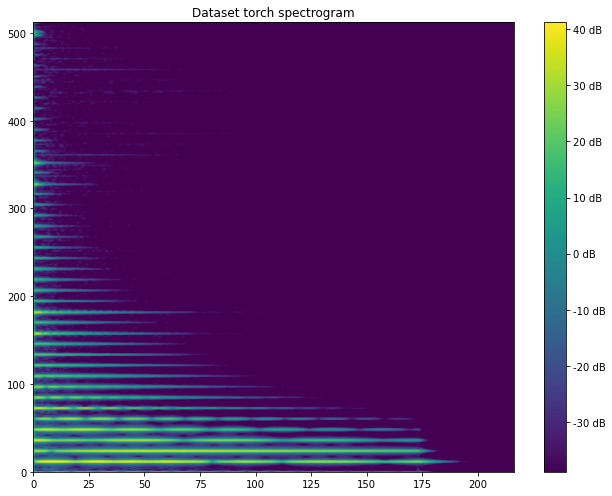

In [2]:
spectrogram, params, midi = one_sample
spectrogram_size = dexed_dataset.get_spectrogram_tensor_size()
print("Dataset Spectrogram size: {}x{} = {} pixels\nOriginal raw audio: {} samples (22.050kHz, 5.0s))"
      .format(spectrogram_size[0], spectrogram_size[1],
              spectrogram_size[0]*spectrogram_size[1], 5 * 22050))

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.set(title="Dataset torch spectrogram")
im = ax.pcolormesh(spectrogram, shading='gouraud')
fig.colorbar(im, ax=ax, orientation='vertical', format='%.0f dB')
fig.tight_layout()

In [3]:
import torch
import os
# dataloader test
dexed_dataloader = torch.utils.data.DataLoader(dexed_dataset, batch_size=128, shuffle=False,
                                               num_workers=8)
sample = None
for i, sample in enumerate(dexed_dataloader):
    pass  # pour voir le dataset complet...
    if i%10 == 0:
        print("batch {}".format(i))
print(sample)

/home/gwendal/Jupyter/nn-synth-interp/synth/dexed.py:187: RuntimeWarning: invalid value encountered in true_divide
  return audio / np.abs(audio).max()


KeyboardInterrupt: 